In [83]:
import pandas as pd
import cv2
import numpy as np
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt



# 2.2

In [84]:
class KDE():
    def __init__(self, kernel_type='box'):
        self.kernel_type = kernel_type
        self.bandwidth = None
        self.X = None

    def kernel_function(self, X):
        if self.kernel_type == 'box':
            return np.where(np.abs(X) <= 1, 0.5, 0)
        elif self.kernel_type == 'triangular':
            return np.where(np.abs(X) <= 1, 1 - np.abs(X), 0)
        elif self.kernel_type == 'gaussian':
            return 1 / (np.sqrt(2 * np.pi)) * np.exp(-0.5 * X**2)

    def pseudo_likelihood(self, bandwidth):
        diffs = self.X - self.X[:, None]
        kernel_output = self.kernel_function(diffs[~np.eye(self.X.shape[0], dtype=bool)].reshape(self.X.shape[0], -1, self.X.shape[1]) / bandwidth)
        return -np.mean(np.log(np.mean(np.sum(kernel_output, axis=1), axis=1) / bandwidth, where=lambda x: x > 0))
    
    def opt_bandwidth(self):
        initial_bandwidth = np.std(self.X) * (4 / (3 * self.X.shape[0]))**0.2
        optimal_bandwidth = minimize(
            fun=self.pseudo_likelihood,
            x0=initial_bandwidth,
            bounds=((1e-5, None),)
        ).x[0]
        return optimal_bandwidth

    def fit(self, X):
        self.X = X
        if(X.ndim == 1):
            self.X = X.reshape(-1,1)
        self.bandwidth  = self.opt_bandwidth()
    def evaluate_density(self, X):
        X_reshaped = X.reshape(-1, self.X.shape[1])
        kernel_output = self.kernel_function((X_reshaped[:, None] - self.X) / self.bandwidth)
        return np.sum(np.sum(kernel_output, axis=1), axis=1) / (self.X.shape[0] * self.bandwidth)

    def plot_pdf(self, X, ax=None, fig=None):
        if X.ndim == 1:
            X_reshaped = X.reshape(-1, self.X.shape[1])
            density = self.evaluate_density(X)
            if ax is None:
                plt.hist(self.X, bins=50, density=True, color='skyblue', ec='black', alpha=0.7)
                plt.plot(X_reshaped, density, color='darkgreen', lw=3)
                plt.title(f'Kernel Density Estimation (KDE) for 1D Data\nKernel: {self.kernel_type}, Bandwidth: {np.round(self.bandwidth, 3)}')
                plt.show()
            else:
                ax.hist(self.X, bins=50, density=True, color='skyblue', ec='black', alpha=0.7)
                ax.plot(X_reshaped, density, color='darkgreen', lw=3)
                ax.set_title(f'Kernel Density Estimation (KDE) for 1D Data\nKernel: {self.kernel_type}, Bandwidth: {np.round(self.bandwidth, 3)}')
        elif X.ndim == 2:
            x_min = X[:, 0].min()
            x_max = X[:, 0].max()
            y_min = X[:, 1].min()
            y_max = X[:, 1].max()
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
            pos = np.vstack([xx.ravel(), yy.ravel()])
            densities = self.evaluate_density(pos.T)
            densities = densities.reshape(xx.shape)
            if ax is None:
                plt.contourf(xx, yy, densities, cmap='Blues', levels=50, alpha=0.7)
                plt.scatter(self.X[:, 0], self.X[:, 1], color='orange', alpha=0.5)
                plt.xlim(x_min, x_max)
                plt.ylim(y_min, y_max)
                plt.title(f'Kernel Density Estimation (KDE) for 2D Data\nKernel: {self.kernel_type}, Bandwidth: {np.round(self.bandwidth, 3)}')
                plt.colorbar()
                plt.show()
            else:
                contour = ax.contourf(xx, yy, densities, cmap='Blues', levels=50, alpha=0.7)
                ax.scatter(self.X[:, 0], self.X[:, 1], color='orange', alpha=0.5)
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_min, y_max)
                ax.set_title(f'Kernel Density Estimation (KDE) for 2D Data\nKernel: {self.kernel_type}, Bandwidth: {np.round(self.bandwidth, 3)}')
                fig.colorbar(contour, ax=ax)

/tmp/ipykernel_17501/410734178.py:18: RuntimeWarning: divide by zero encountered in log
  return -np.mean(np.log(np.mean(np.sum(kernel_output, axis=1), axis=1) / bandwidth, where=lambda x: x > 0))


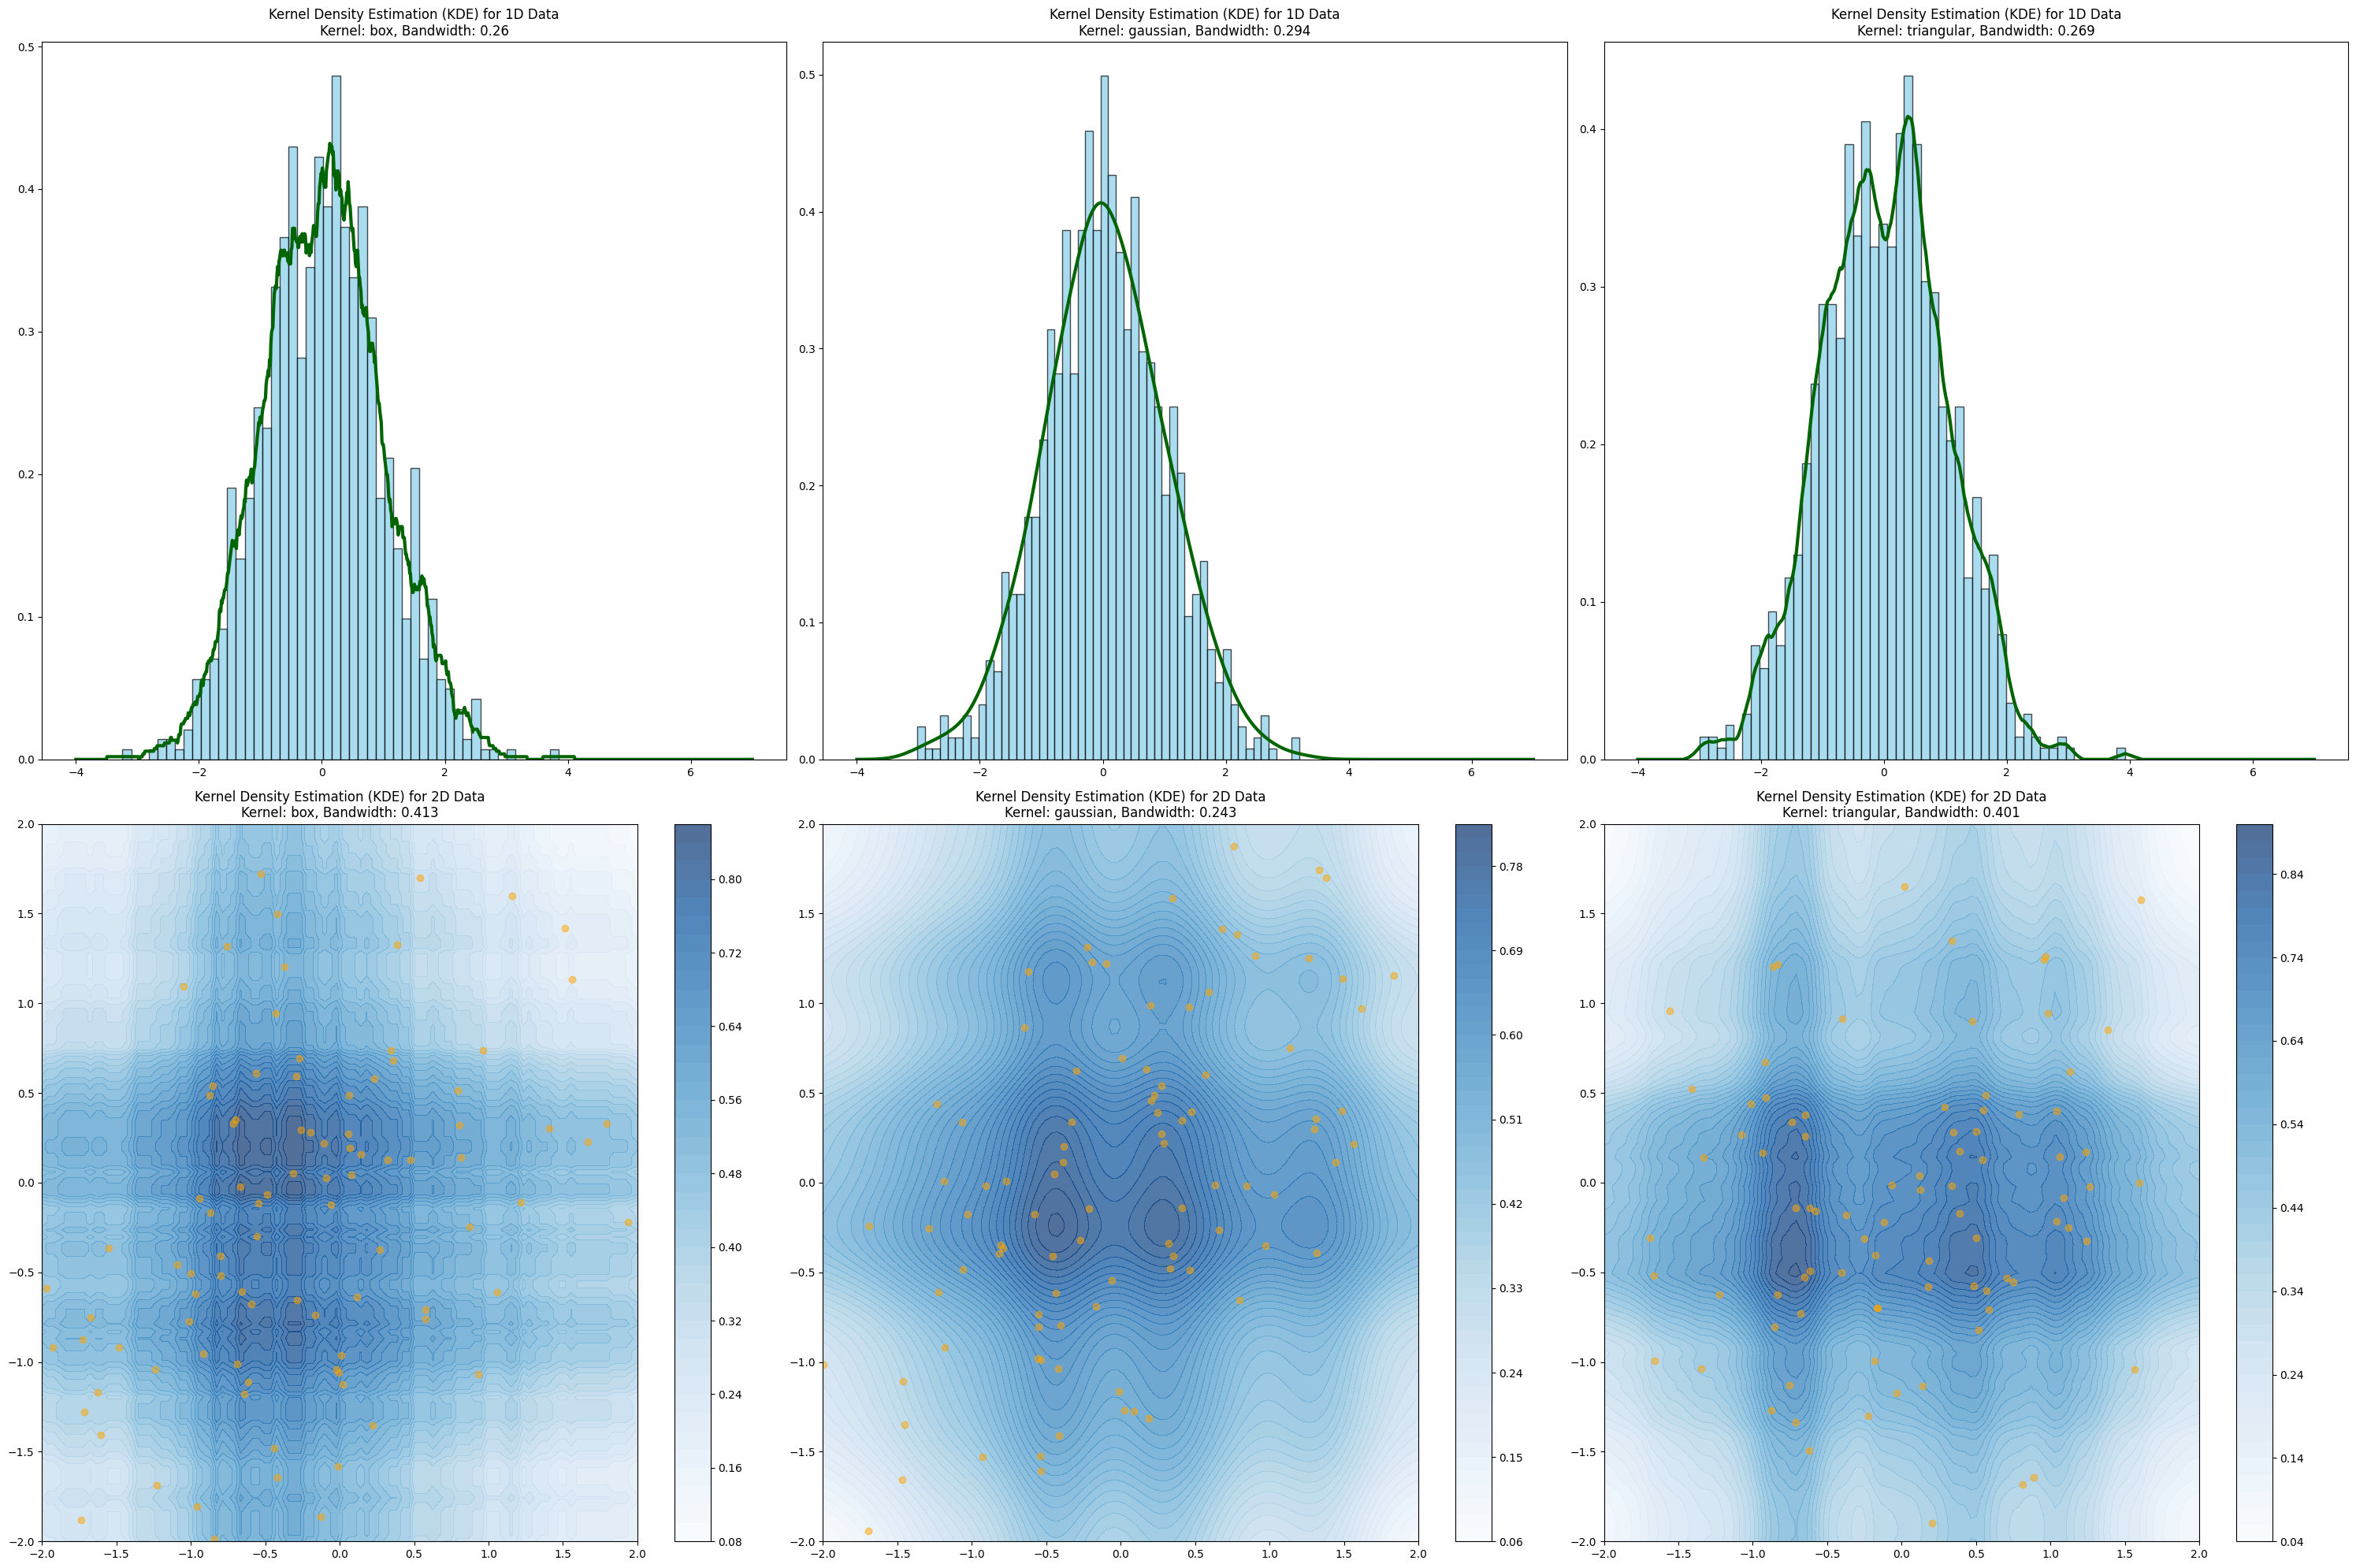

In [96]:
np.random.seed(42)
kernels  = ['box', 'gaussian', 'triangular']
fig, axes = plt.subplots(2, 3, figsize=(30, 20))

for i, kernel in enumerate(kernels):
    normal_1d = np.random.normal(loc=0, scale=1, size=1000)
    test_data_1d = np.linspace(-4, 7, 1000)
    normal_2d = np.random.multivariate_normal(mean=[0, 0], cov=[[1, 0.5], [0.5, 1]], size=100)
    X, Y = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
    test_data_2d = np.vstack([X.ravel(), Y.ravel()]).T
    kde1 = KDE(kernel_type=kernel)
    kde1.fit(normal_1d)
    kde1.plot_pdf(test_data_1d, ax=axes[0, i], fig=fig)
    kde2 = KDE(kernel_type=kernel)
    kde2.fit(normal_2d)
    kde2.plot_pdf(test_data_2d, ax=axes[1, i], fig=fig)
fig.tight_layout()

# 2.3 